In [1]:
import warnings, os, datetime, zipfile, tqdm, gdown, glob, random, shutil, pytz
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
timezone = pytz.timezone('Europe/Paris')
now = datetime.datetime.now(timezone).strftime('%Y.%m.%d-%H.%M.%S')

project_path = os.getcwd()

paths = {
    "data_path": f"{project_path}/data",
    "train_data_path": f"{project_path}/data/train",
    "validation_data_path": f"{project_path}/data/validation",
    "unsorted_validation_data_path": f"{project_path}/data/validation/unsorted",
    "sorted_validation_data_path": f"{project_path}/data/validation/sorted",
    "model_path": f"{project_path}/models",
    "checkpoint_path": f"{project_path}/weights/model_early",
    "log_path": f"{project_path}/logs/fit/{now}_model"
}

paths_to_delete = [
    "unsorted_validation_data_path",
    "sorted_validation_data_path"
]

for key, path in paths.items():
    if key in paths_to_delete and os.path.exists(path):
        print(f"Deleting {path}")
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)

image_h = 224
image_w = 224
batch_s = 24

encoding_dim = 256

In [3]:
def download_dataset(force=False):
    # Construct the dataset path
    dataset_path = os.path.join(paths['train_data_path'], 'dataset_livrable_2.zip')

    # Check if the dataset is already downloaded
    if os.path.exists(dataset_path) and not force:
        print("Dataset is already downloaded.")
    else:
        print("Downloading dataset...")
        url = 'https://drive.google.com/uc?export=download&id=1WdcW_OqvRyuLiGx0FiZR0KmrqB9VYsLw'
        gdown.download(url, dataset_path, quiet=False)
    
    # Check if the dataset is already extracted
    if len(os.listdir(paths['train_data_path'])) == 2 and not force:
        print("Dataset is already extracted.")
    else:
        print("Extracting dataset...")
        with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
            files = zip_ref.infolist()
            with tqdm.tqdm(total=len(files), desc="Extracting", unit="file") as pbar:
                for file in files:
                    zip_ref.extract(file, paths['train_data_path'])
                    pbar.update(1)
            print(f"Dataset extracted to {paths['train_data_path']}")
        
# Call the function
download_dataset()

Downloading...
From: https://drive.google.com/uc?export=download&id=1WdcW_OqvRyuLiGx0FiZR0KmrqB9VYsLw
To: /Users/mohamed/Documents/FISE A5/z/livrable_2/data/train/dataset_livrable_2.zip
100%|██████████| 18.7M/18.7M [00:00<00:00, 22.1MB/s]


Extracting dataset...


Extracting: 100%|██████████| 149/149 [00:00<00:00, 2197.89file/s]

Dataset extracted to /Users/mohamed/Documents/FISE A5/z/livrable_2/data/train


In [4]:
def check_images_in_dataset(dataset_path):
    # Get the paths of all image files (jpg, png, etc.)
    img_paths = glob.glob(os.path.join(dataset_path, '*/*.*'))  # You can specify extensions like '*.jpg' if necessary

    for img_path in tqdm.tqdm(img_paths, desc="Checking images"):
        try:
            # Read and decode the image to check if it is valid
            img_bytes = tf.io.read_file(img_path)
            tf.io.decode_image(img_bytes)

        except tf.errors.InvalidArgumentError as e:
            # Catch specific TensorFlow error and remove bad files
            print(f"Found corrupt image: {img_path}. Error: {str(e)}. Removing it.")
            os.remove(img_path)
        except Exception as e:
            # General exception handler for other possible issues
            print(f"Error processing image: {img_path}. Error: {str(e)}. Removing it.")
            os.remove(img_path)

# Call the function to check the images in the train data path
check_images_in_dataset(paths['train_data_path'])


Checking images: 100%|██████████| 148/148 [00:00<00:00, 594.89it/s]


In [5]:
# Load and split images into train and test sets (80%-20%)
train_set, test_set = tf.keras.preprocessing.image_dataset_from_directory(
    paths['train_data_path'],
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s,
    labels=None,
    label_mode=None
)

Found 148 files.
Using 119 files for training.
Using 29 files for validation.


Remarque sympa de notre ami le chat : 

Distribution du bruit : Si tu souhaites tester d'autres types de bruit, tu pourrais explorer différentes distributions (par exemple du bruit impulsionnel ou du bruit Poisson) en plus du bruit gaussien pour diversifier encore plus les perturbations appliquées aux images.

In [6]:
# Adding the resizing layer
rescale_layer = tf.keras.layers.Rescaling(1./255)

# Adds Gaussian noise to images, keeping pixel values in [0, 1].
def add_gaussian_noise(images, min_noise=0.7, max_noise=0.9):
    batch_size = tf.shape(images)[0]
    noise_factor = tf.random.uniform(shape=(batch_size, 1, 1, 1), minval=min_noise, maxval=max_noise)
    noise = tf.random.normal(shape=tf.shape(images))
    noisy_images = images + noise_factor * noise
    noisy_images = tf.clip_by_value(noisy_images, 0.0, 1.0)
    return noisy_images

# Creating datasets with noise
noisy_train_set = train_set.map(
    lambda x: (add_gaussian_noise(rescale_layer(x)), rescale_layer(x)),
    num_parallel_calls=tf.data.AUTOTUNE
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Adds Gaussian noise and rescales the test set images, optimizing with parallel processing.
noisy_test_set = test_set.map(
    lambda x: (add_gaussian_noise(rescale_layer(x)), rescale_layer(x)),
    num_parallel_calls=tf.data.AUTOTUNE
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

2024-10-11 12:49:46.509545: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-11 12:49:46.539540: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


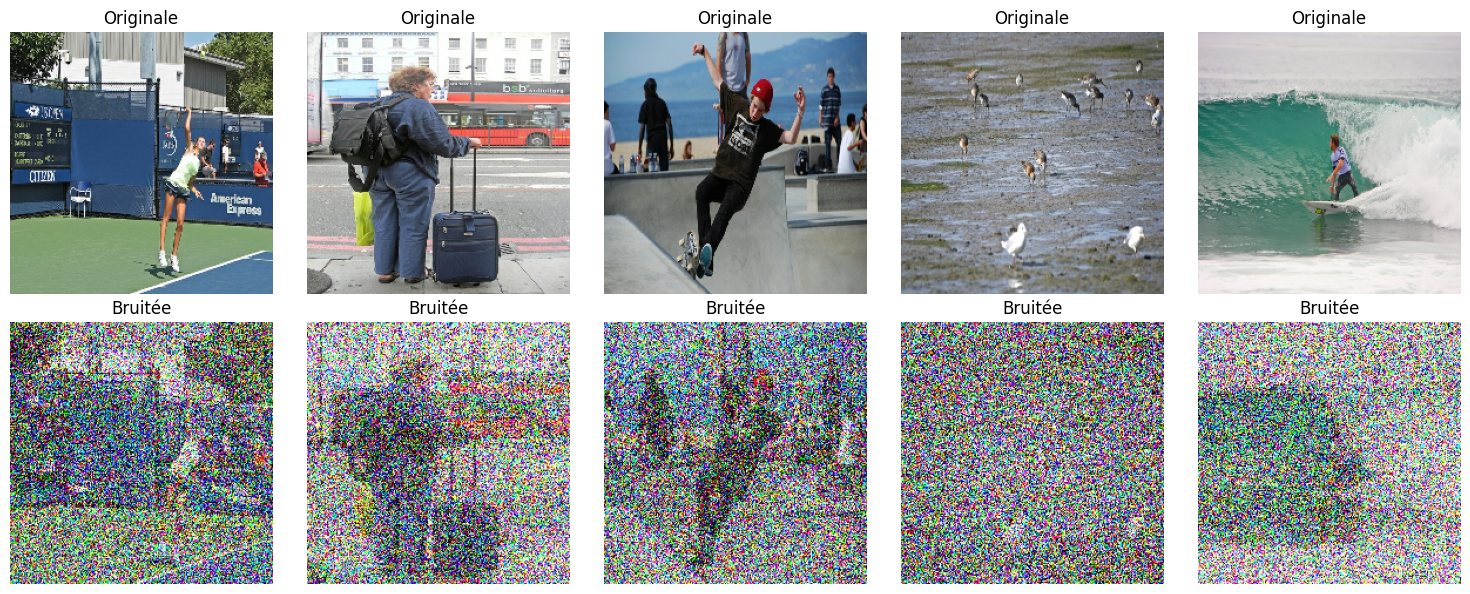

2024-10-11 12:49:47.307711: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


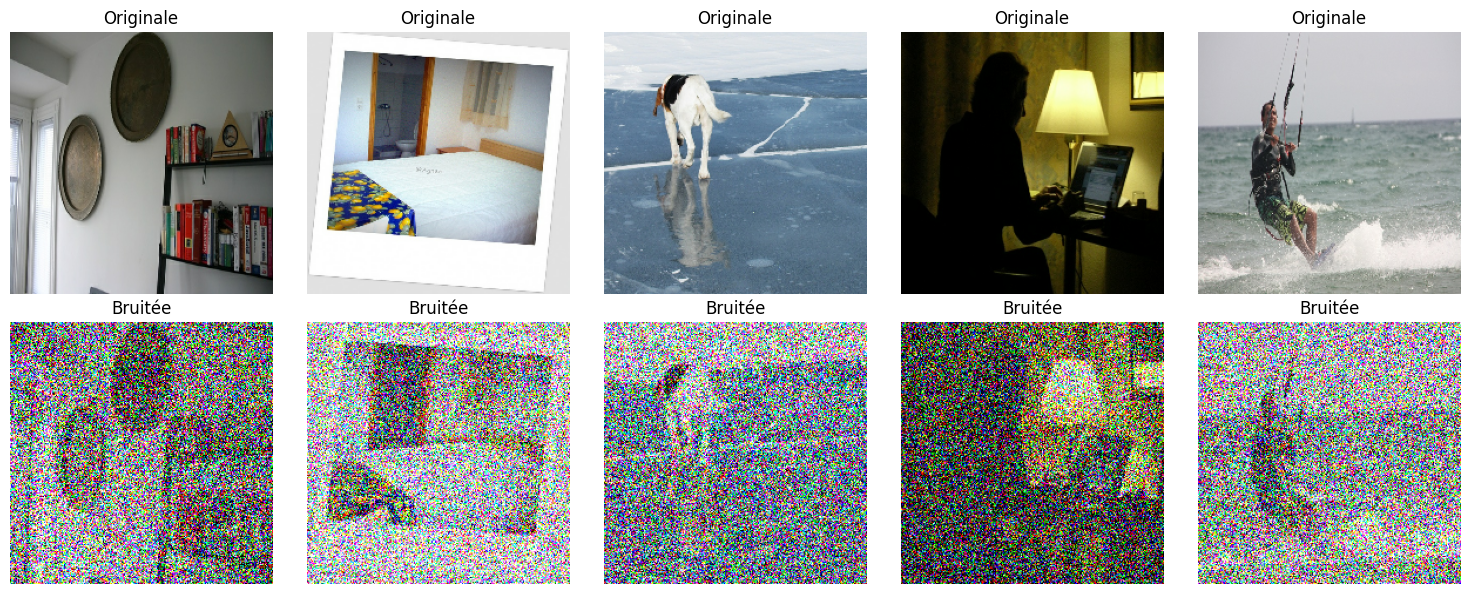

In [7]:
# Function for displaying original and noisy images
def display_noisy_train_images(noisy_dataset, num_images=5):
    plt.figure(figsize=(15, 6))

    for noisy_images, original_images in noisy_dataset.take(1):
        for i in range(num_images):
            # Original pictures
            plt.subplot(2, num_images, i + 1)
            plt.imshow(original_images[i].numpy())
            plt.title('Originale')
            plt.axis('off')

            # Noisy images
            plt.subplot(2, num_images, num_images + i + 1)
            plt.imshow(noisy_images[i].numpy())
            plt.title('Bruitée')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

display_noisy_train_images(noisy_train_set, num_images=5)
display_noisy_train_images(noisy_test_set, num_images=5)

In [8]:
def build_autoencoder(input_shape):
    input_img = tf.keras.layers.Input(shape=input_shape)
    
    # **Encoder**
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # **Decoder**
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    
    decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    # **Self-encoding model**
    autoencoder = tf.keras.Model(input_img, decoded)
    return autoencoder

# **Model construction**
input_shape = (image_h, image_w, 3)
autoencoder = build_autoencoder(input_shape)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,731 (194.26 KB)

 Trainable params: 49,731 (194.26 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# **Defining callbacks**
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# **Model training**
history = autoencoder.fit(
    noisy_train_set,
    epochs=50,
    validation_data=noisy_test_set,
    callbacks=[early_stopping]
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 691ms/step - loss: 0.0795 - val_loss: 0.0744
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step - loss: 0.0712 - val_loss: 0.0592
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step - loss: 0.0522 - val_loss: 0.0328
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step - loss: 0.0291 - val_loss: 0.0284
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step - loss: 0.0269 - val_loss: 0.0241
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step - loss: 0.0222 - val_loss: 0.0231
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step - loss: 0.0223 - val_loss: 0.0238
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step - loss: 0.0220 - val_loss: 0.0220
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step - loss: 0.0213 - val_loss: 0.0211
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step - loss: 0.0203 - val_loss: 0.0210
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 742ms/step - loss: 0.0201 - val_loss: 0.0206
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 712ms/step - loss: 0.0197 - val_lo

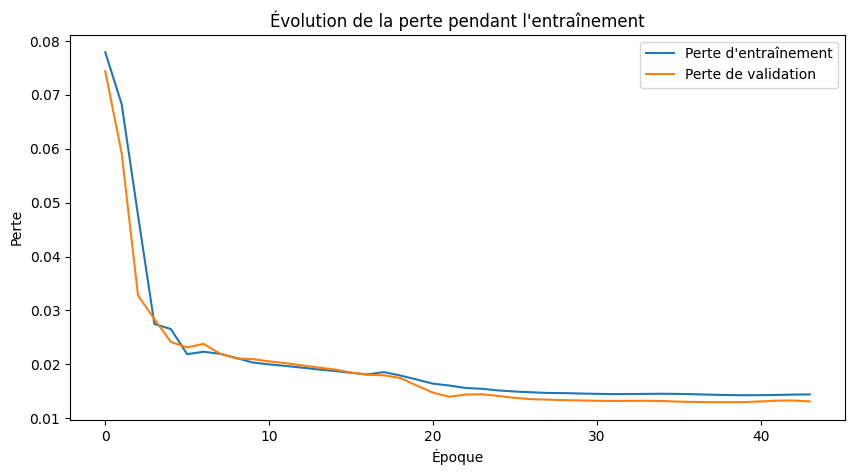

In [10]:
# **Drawing loss curves**
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.title('Évolution de la perte pendant l\'entraînement')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


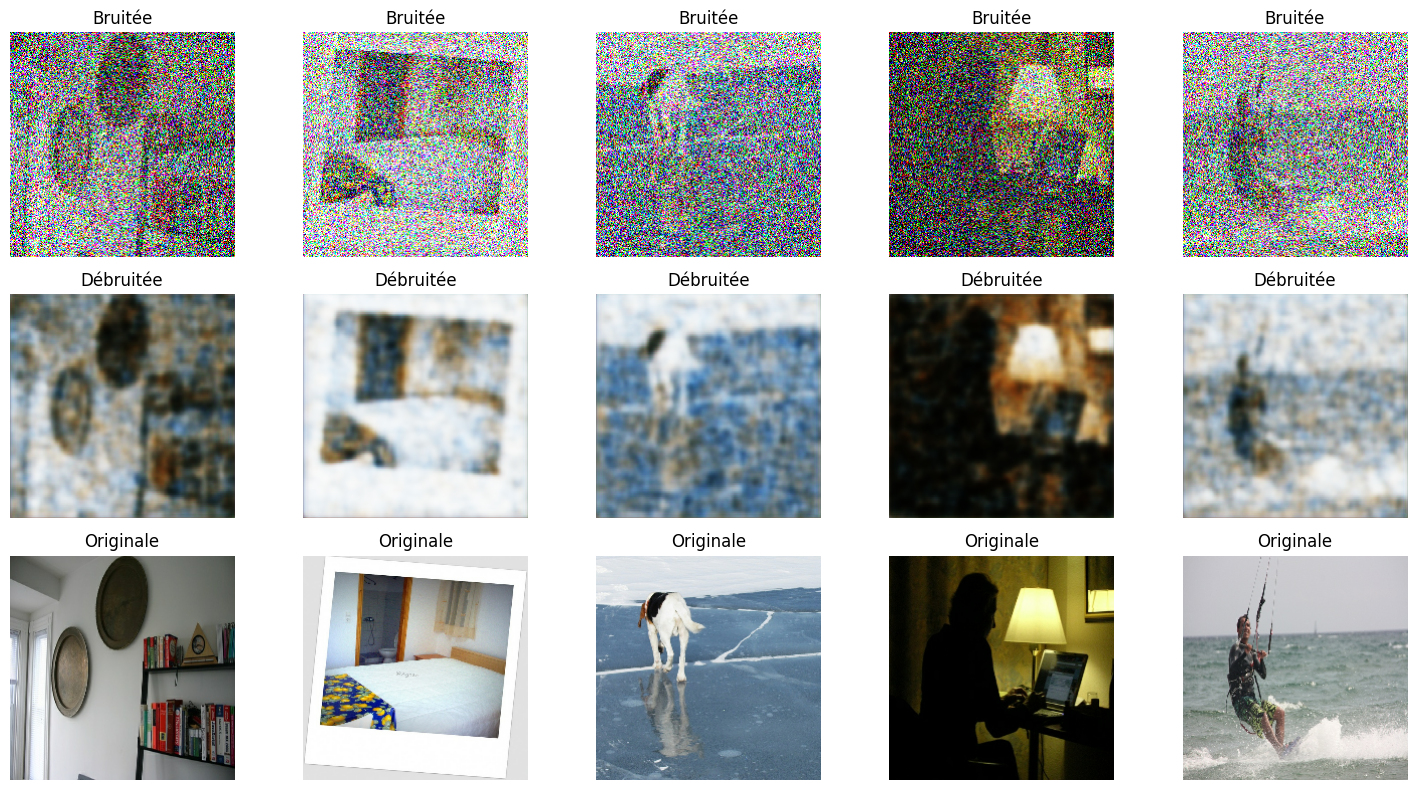

In [11]:
def display_denoised_images(model, dataset, num_images=5):
    plt.figure(figsize=(15, 8))

    for noisy_images, original_images in dataset.take(1):
        # Predicting denoised pictures
        denoised_images = model.predict(noisy_images)
        
        for i in range(num_images):
            # **Noisy images**
            plt.subplot(3, num_images, i + 1)
            plt.imshow(noisy_images[i].numpy())
            plt.title('Bruitée')
            plt.axis('off')
            
            # **Denoised images**
            plt.subplot(3, num_images, num_images + i + 1)
            plt.imshow(denoised_images[i])
            plt.title('Débruitée')
            plt.axis('off')
            
            # **Original picture**
            plt.subplot(3, num_images, 2 * num_images + i + 1)
            plt.imshow(original_images[i].numpy())
            plt.title('Originale')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# **Displaying results**
display_denoised_images(autoencoder, noisy_test_set, num_images=5)